In [1]:
"""
play around with plotting gene expression across a border

Shaina Lu
Zador and Gillis Labs
September 2020
"""

'\nplay around with plotting gene expression across a border\n\nShaina Lu\nZador and Gillis Labs\nSeptember 2020\n'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

### Read in files and pre-processing

In [4]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"

In [5]:
#ABA
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

In [7]:
#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()
STmeta, STspots, STpropont = read_STdata()

okay, options:
- look in the datasets independently
- filter for overlapping areas and genes
- look indepedently, but only use genes in both datasets (best I think, b/c don't need leaf resolution)

In [12]:
#copied from 09_crossdataset.ipynb
def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox

In [13]:
#keep only genes that are overlapping between the two datasets
STspots, ABAvox = getoverlapgenes(STspots, ABAvox)

number of overlapping genes: 14299


In [14]:
list(STspots) == list(ABAvox)

True

In [20]:
print(STspots.shape)
print(ABAvox.shape)
print(STmeta.shape)
print(ABAmeta.shape)

(30780, 14299)
(62527, 14299)
(30780, 11)
(62527, 4)


In [28]:
#read in file w/ vox coords
COORD_PATH = "/data/slu/allen_adult_mouse_ISH/voxelCoordinates.csv"
allcoords = pd.read_csv(COORD_PATH)
ABAcoords = allcoords[allcoords.index.isin(ABAvox.index)] #keep only those in filtered voxbrain

In [29]:
ABAcoords.shape

(62527, 3)

### figure out an AP location to start with

In [19]:
STmeta.head()

,slice_index,ML,DV,AP,acronym,name,nuclei,radius,x,y,id
02A_15.8x13.04,02A,3.156438,-3.545032,2.245,MOp1,"Primary motor area, Layer 1",3,72.832245,3479.641,4936.516,320
02A_18.75x13.07,02A,3.012475,-2.692800,2.245,MOp1,"Primary motor area, Layer 1",1,76.475977,3491.171,4074.165,320
02A_16.74x13.07,02A,3.124975,-3.292800,2.245,MOp1,"Primary motor area, Layer 1",1,75.797361,3488.927,4661.036,320
02A_17.81x13.08,02A,3.064854,-2.974134,2.245,MOp1,"Primary motor area, Layer 1",5,73.206277,3493.646,4348.148,320
02A_19.96x14.09,02A,2.831225,-2.405300,2.245,MOp1,"Primary motor area, Layer 1",2,77.408797,3783.901,3720.984,320


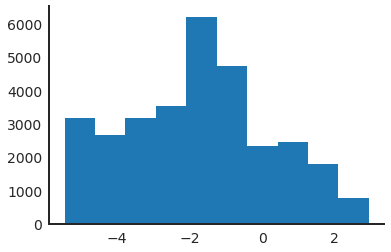

In [27]:
plt.hist(STmeta.AP)
plt.show()

How do I determine an AP location in ST that is synonymous with a coronal slice in the x,y,z system of ABA? Start with just working with median of Allen? \
\
From previous visualization (allenadultmouseISH/visualize_twelve.ipynb), x-cooridinate captures AP location in ABA.

In [31]:
ABAcoords.xcord.median()

38.0

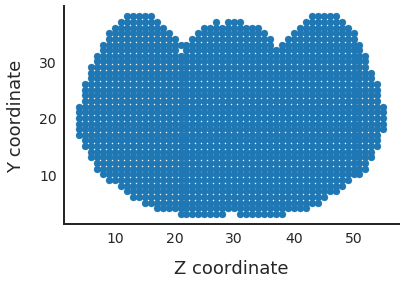

In [39]:
Xslice = ABAcoords.loc[ABAcoords.xcord == 38.0]
plt.scatter(Xslice.zcord, Xslice.ycord)
plt.xlabel("Z coordinate")
plt.ylabel("Y coordinate")
plt.savefig("092320_1.pdf", bbox_inches='tight')
plt.show()

In [44]:
Xline = Xslice.loc[Xslice.zcord == 20]
Xlinevox = ABAvox.loc[Xline.index]

In [51]:
#Xline is already in the order of increasing ycord so no need to sort
Xline.head()

,xcord,ycord,zcord
52431,38,4,20
52498,38,5,20
52565,38,6,20
52632,38,7,20
52699,38,8,20


In [53]:
#what brain areas are captured in these voxels
ABAmeta.loc[Xline.index]

,ids,acronym,color,name
52431,241,PTLp2/3,009FAC,Posteri
52498,241,PTLp2/3,009FAC,Posteri
52565,683,PTLp5,009FAC,Posteri
52632,308,PTLp6a,009FAC,Posteri
52699,8,grey,BFDAE3,Basic c
52766,407,CA1sp,66A83D,Field C
52833,415,CA1sr,7ED04B,Field C
52900,391,CA1slm,7ED04B,Field C
52967,10703,DG-mo,7ED04B,Dentate
53034,632,DG-sg,66A83D,Dentate


In [56]:
#first try picking a few genes to focus on as those with highest variance
Xlinevar = Xlinevox.var(axis=0)

In [62]:
Xlinevar.sort_values(ascending=False, inplace=True)

In [67]:
Xlinevar.index[0]

'Fbxo22'

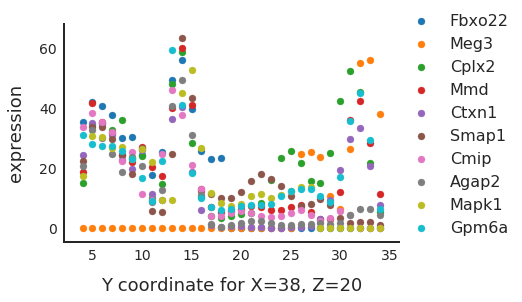

In [85]:
for i in range(10):
    plt.scatter(Xline.ycord, Xlinevox[Xlinevar.index[i]],label=Xlinevar.index[i])
plt.xlabel("Y coordinate for X=38, Z=20")
plt.ylabel("expression")
plt.legend(loc=[1,0])
plt.savefig("092320_3.pdf", bbox_inches='tight')
plt.show()

In [86]:
#try making a plot crossing in the other direciton, fixed y cord
currline = Xslice.loc[Xslice.ycord == 20]
currlinevox = ABAvox.loc[currline.index]

In [88]:
#currline is already in order of increasing zcord so no need to sort
#currline

In [89]:
#get highest variance genes for these voxels
currvar = currlinevox.var(axis=0)
currvar.sort_values(ascending=False, inplace=True)

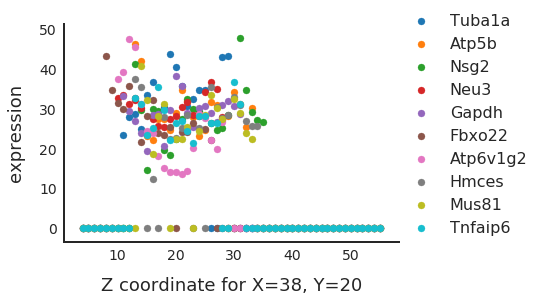

In [94]:
for i in range(10):
    plt.scatter(currline.zcord, currlinevox[currvar.index[i]],label=currvar.index[i])
plt.xlabel("Z coordinate for X=38, Y=20")
plt.ylabel("expression")
plt.legend(loc=[1,0])
plt.savefig("092320_5.pdf", bbox_inches='tight')
plt.show()

In [95]:
ABAmeta.loc[currline.index]

,ids,acronym,color,name
9551,959,AUDv1,019399,Ventral
12298,755,AUDv2/3,019399,Ventral
15045,1023,AUDv5,019399,Ventral
17792,1023,AUDv5,019399,Ventral
20539,520,AUDv6a,019399,Ventral
23286,598,AUDv6b,019399,Ventral
26033,672,CP,98D6F9,Caudopu
28780,672,CP,98D6F9,Caudopu
31527,8,grey,BFDAE3,Basic c
34274,8,grey,BFDAE3,Basic c


In [97]:
ABAcoords.loc[currline.index]

,xcord,ycord,zcord
9551,38,20,4
12298,38,20,5
15045,38,20,6
17792,38,20,7
20539,38,20,8
23286,38,20,9
26033,38,20,10
28780,38,20,11
31527,38,20,12
34274,38,20,13
